## Maintenance Contract – Cluster Monitoring & Retraining

This notebook implements a “maintenance contract” for the customer segmentation model (M0). Its goal is to monitor when the clustering model degrades over time and to define a clear retraining cadence based on both cluster stability and feature drift.

**Key objectives:**
1. **Simulate Cluster Drift**  
   - Use the Adjusted Rand Index (ARI) to compare the original K-Means segmentation (M0) against fresh re-fits at weekly snapshots.  
   - Identify the week when ARI falls below our 0.8 threshold (≈90 % label agreement), triggering a model retrain.

2. **Assess Feature Stability**  
   - For each continuous feature (e.g. recency, log spend), run two-sample KS tests between week 0 and each subsequent week.  
   - For binary flags (e.g. returning‐customer), apply chi-square tests to detect any shifts in proportions.

3. **Define Maintenance Cadence**  
   - Combine ARI decline and feature-drift signals to recommend a retraining interval (e.g. every 12 weeks).  
   - Highlight which features drive most of the drift—and which segments require the most urgent attention.

## Load data

In [2]:
# Libraries
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp, chi2_contingency

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [3]:
# Load the data
df = pd.read_csv("./data/processed/processed_database.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93350 entries, 0 to 93349
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93350 non-null  object 
 1   order_purchase_timestamp  93350 non-null  object 
 2   recency                   93350 non-null  int64  
 3   f_returning               93350 non-null  int64  
 4   m_price                   93350 non-null  float64
 5   m_price_log               93350 non-null  float64
 6   m_purchasing_power        93350 non-null  int64  
 7   s_review_score            93350 non-null  float64
 8   s_delivery_diff           93350 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 6.4+ MB


In [4]:
# Parse timestamps
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

T0 = df['order_purchase_timestamp'].max()

df['weeks_since'] = ((T0 - df['order_purchase_timestamp'])
                     .dt.total_seconds() 
                   / (7*24*3600)) \
                    .round().astype(int)

## Functions

In [6]:
def simulate_ari_drift(df, features, model, scaler, k, max_weeks=24, threshold=0.6):
    """
    Simulate ARI-based maintenance drift.
    """
    results = []
    for w in range(0, min(df['weeks_since'].max(), max_weeks) + 1):
        snap = df[df['weeks_since'] >= w]
        Xw_s = scaler.transform(snap[features].values)
        C_init = model.predict(Xw_s)
        C_new = KMeans(n_clusters=k, random_state=42).fit_predict(Xw_s)
        ari = adjusted_rand_score(C_init, C_new)
        results.append({'weeks_since': w, 'ari': ari})
        if ari < threshold:
            break
    return pd.DataFrame(results)

In [7]:
def plot_ari_drift(df_ari, threshold=0.8, xtick_step=2,
                   xlabel='Weeks since initial fit (T0)',
                   ylabel='Adjusted Rand Index',
                   title='Model Validity Over Time',
                   outpath=None):
    """
    Plot ARI drift over time.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_ari['weeks_since'], df_ari['ari'], marker='o', linestyle='-')
    ax.axhline(threshold, color='red', linestyle='--', label=f'ARI = {threshold}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    max_week = df_ari['weeks_since'].max()
    ax.set_xticks(range(0, max_week + 1, xtick_step))
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=150)
    plt.show()

In [8]:
def ks_drift_tests(df, features, max_week=12):
    """
    Perform KS tests for continuous feature drift.
    """
    ks_results = []
    baseline = df[df['weeks_since'] == 0]
    for feat in features:
        data0 = baseline[feat]
        for w in range(1, min(df['weeks_since'].max(), max_week) + 1):
            dataw = df[df['weeks_since'] == w][feat]
            if len(dataw) < 10:
                continue
            stat, pval = ks_2samp(data0, dataw)
            ks_results.append({
                'feature': feat,
                'week': w,
                'ks_stat': stat,
                'pvalue': pval
            })
    return pd.DataFrame(ks_results)

In [99]:
def chi2_drift_tests(df, feature, max_week=12):
    """
    Perform chi-square tests for binary feature drift.
    """
    base = df[df['weeks_since'] == 0][feature].value_counts().sort_index().reindex([0,1], fill_value=0)
    chi_results = []
    for w in range(1, min(df['weeks_since'].max(), max_week) + 1):
        comp = (df[df['weeks_since'] == w][feature]
                .value_counts().sort_index()
                .reindex([0,1], fill_value=0))
        table = pd.DataFrame({'week0': base, f'week{w}': comp})
        chi2, p, dof, expected = chi2_contingency(table.values)
        chi_results.append({'week': w, 'chi2_stat': chi2, 'p_value': p})
    return pd.DataFrame(chi_results).set_index('week')

In [10]:
def plot_feature_drift(df_ks, df_chi, max_week=12):
    """
    Plot KS p-values for continuous features and chi-square p-values for one binary feature
    in a shared-x two-panel figure.
    """
    weeks = range(1, max_week+1)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

    # Top: KS tests
    for feat in df_ks['feature'].unique():
        sub = df_ks[df_ks['feature']==feat]
        ax1.plot(sub['week'], sub['pvalue'], marker='o', label=feat)
    ax1.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
    ax1.set_ylabel('KS p-value')
    ax1.set_title('Continuous Feature Drift (KS Test)')
    ax1.legend(loc='upper right')

    # Bottom: Chi-square test
    ax2.plot(
        df_chi.index, df_chi['p_value'],
        marker='s', color='tab:blue', label=df_chi.columns[0]
    )
    ax2.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
    ax2.set_xlabel('Weeks since initial fit (T0)')
    ax2.set_ylabel('Chi-square p-value')
    ax2.set_title('Binary Feature Drift (Chi-square Test)')
    ax2.legend(loc='upper right')

    plt.xticks(weeks)
    plt.tight_layout()
    plt.show()

## Model 0 : RFM

In [12]:
features = ['recency', 'f_returning', 'm_price_log']

X = df[features].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

best_k = 4

km0 = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
df['cluster0'] = km0.labels_

### Cluster drift

The Adjusted Rand Index (ARI) is used to determine cluster drift in order to determine an appropriate maintenance cadence.

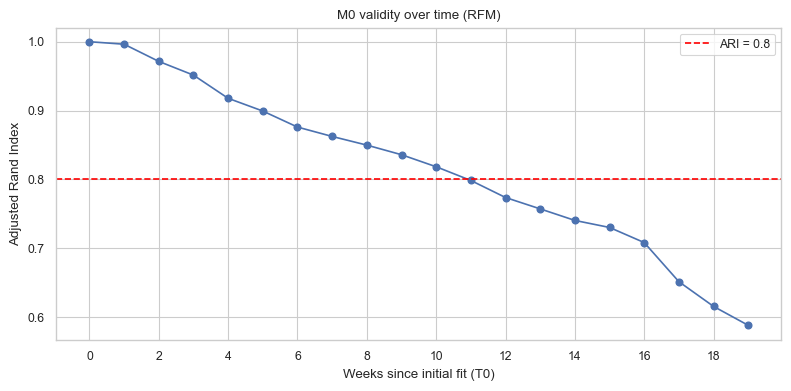

In [14]:
# ARI drift
df_ari = simulate_ari_drift(df, features, km0, scaler, best_k, max_weeks=24)

plot_ari_drift(df_ari,
               threshold=0.8, 
               xtick_step=2,
               title='M0 validity over time (RFM)',
               outpath="./plots/maintenance/M0_ARI.png")

### Feature drift
Kolmogorov–Smirnov tests are used to assess how continious features (recency and m_price_log) shift over time, and a chi-square test is used to assess binary features (f_returning) shifts over time.

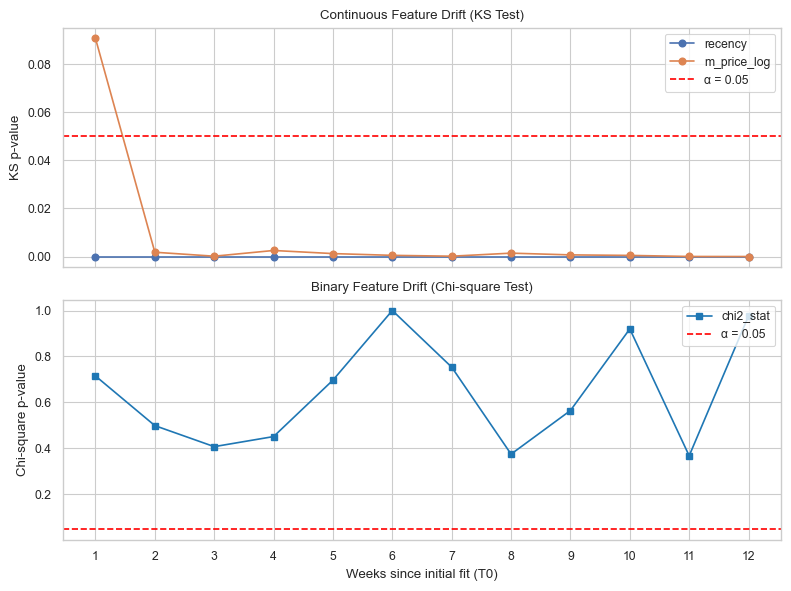

In [16]:
# Chi2 drift
df_chi = chi2_drift_tests(df, 'f_returning', max_week=12)

# KS drift
df_ks  = ks_drift_tests(df, ['recency','m_price_log'], max_week=12)

plot_feature_drift(df_ks, df_chi, max_week=12)

Interpretation:
* Recency: Every week back, the “recency” distribution is completely different, which is no surprise as “recency” is “days since last order”. As such, recency will always drive some of your ARI decay.
* Price: Week 1’s price distribution is statistically the same. Changes in what people spend start to change the clusters after ~2 weeks.
* f_returning is extremely stable over time. The fraction of customers who’ve returned at least once stays essentially constant across all snapshots. It’s a “safe” feature for segmentation. Since it doesn’t drift, it won’t erode cluster definitions. No need for frequent retraining just for this flag.

## Model 1 : RFM + Review Score

In [52]:
features = ['recency', 'f_returning', 'm_price_log', 's_review_score']

X = df[features].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

best_k = 5

km0 = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
df['cluster0'] = km0.labels_

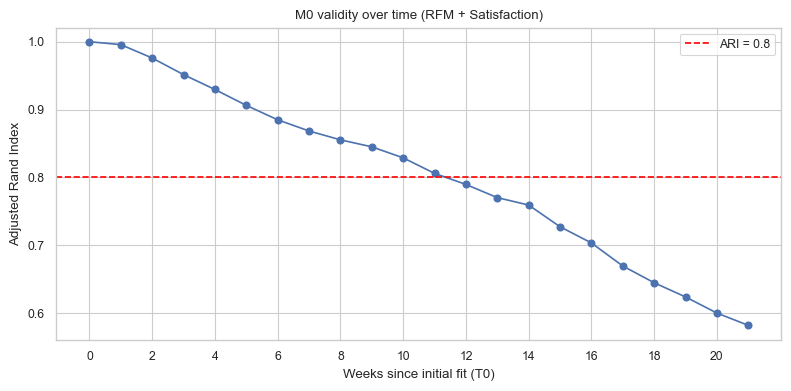

In [54]:
# ARI drift
df_ari = simulate_ari_drift(df, features, km0, scaler, best_k, max_weeks=24)

plot_ari_drift(df_ari,
               threshold=0.8, 
               xtick_step=2,
               title='M0 validity over time (RFM + Satisfaction)',
               outpath=None)

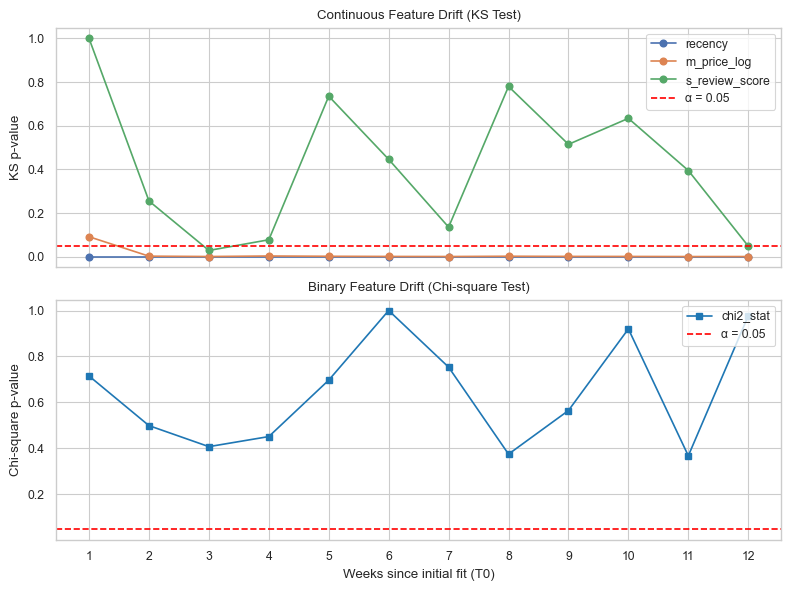

In [56]:
# Chi2 drift
df_chi = chi2_drift_tests(df, 'f_returning', max_week=12)

# KS drift
df_ks  = ks_drift_tests(df, ['recency','m_price_log', 's_review_score'], max_week=12)

plot_feature_drift(df_ks, df_chi, max_week=12)

## Model 2 : RFM + Purchasing Power

In [83]:
features = ['recency', 'f_returning', 'm_price_log', 'm_purchasing_power']

X = df[features].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

best_k = 4

km0 = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
df['cluster0'] = km0.labels_

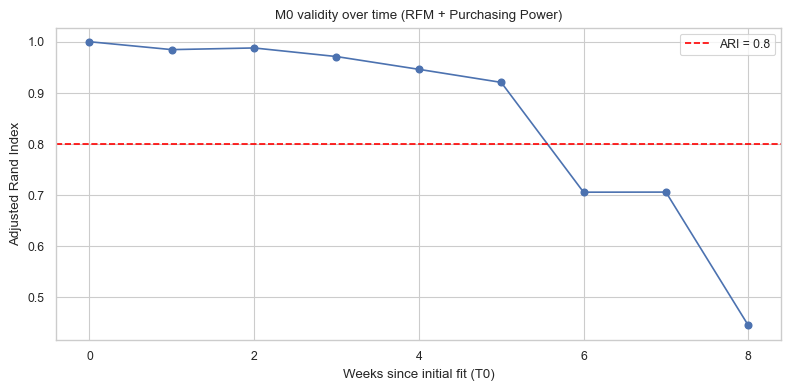

In [87]:
# ARI drift
df_ari = simulate_ari_drift(df, features, km0, scaler, best_k, max_weeks=24)

plot_ari_drift(df_ari,
               threshold=0.8, 
               xtick_step=2,
               title='M0 validity over time (RFM + Purchasing Power)',
               outpath=None)

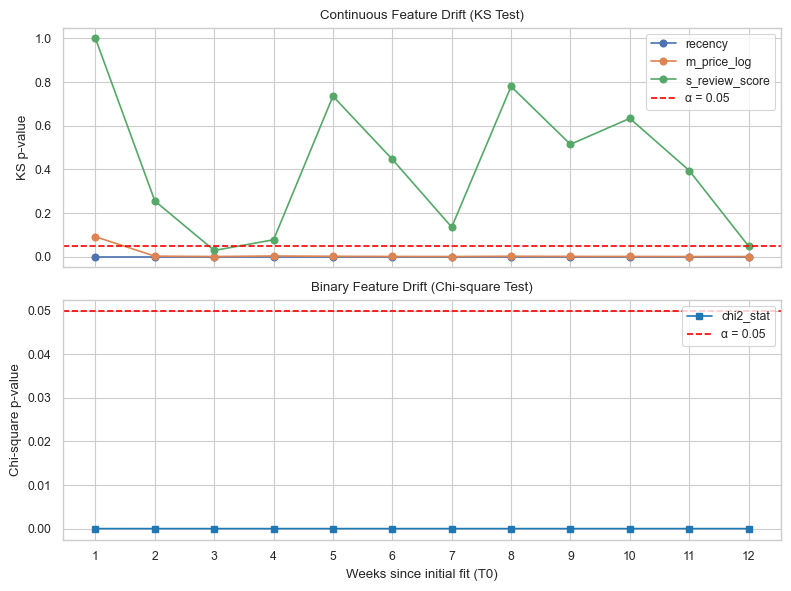

In [101]:
# Chi2 drift
df_chi = chi2_drift_tests(df, 'm_purchasing_power', max_week=12)

# KS drift
df_ks  = ks_drift_tests(df, ['recency','m_price_log', 's_review_score'], max_week=12)

plot_feature_drift(df_ks, df_chi, max_week=12)